In [1]:
import torch
import numpy as np

In [2]:
from datasets import SemEval
from torch import nn, optim
from bert import encode
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import f1_score, classification_report
from math import ceil
from warnings import filterwarnings
from utils import plot_confusion_matrix

In [3]:
filterwarnings("ignore")

In [4]:
class Model(nn.Module):
    
    def __init__(self, input_size, intermediate_size, target_size):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, target_size),
            nn.Softmax(dim=1)
        )
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, inputs, labels=None):
        probabilities = self.classifier(inputs)
        return probabilities, torch.argmax(probabilities, 1), self.cross_entropy(probabilities, labels) if labels is not None else None

In [5]:
def get_model(state_dict=None):
    torch.manual_seed(42)
    model = Model(768, 64, 3).cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

In [6]:
def get_batch(step, batch_size, z):
    batches = ceil(len(z[0]) / batch_size)
    i = step % batches
    start, end = i * batch_size, min((i + 1) * batch_size, len(z[0]))
    return [a[start:end].cuda() for a in z]

In [7]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [ ]:
training_inputs = encode(training.texts, training.targets, method="conditional-target", maximum_length=80).cuda(), torch.tensor(training.stances).cuda()
testing_inputs  = encode(testing.texts,  testing.targets,  method="conditional-target", maximum_length=80).cuda(), torch.tensor(testing.stances ).cuda()

In [ ]:
model = get_model()
batch_size = 48
optimiser = optim.Adam(model.parameters(), lr=1e-4)
step, steps_since, early_stopping = 0, 0, 1000
evaluation_function = lambda true, predicted: f1_score(true, predicted, average="macro")

In [ ]:
optimal_score, optimal_model_state_dict = 0., None

In [ ]:
training_loss, testing_loss = [], []

In [ ]:
while steps_since < early_stopping:

    model.zero_grad()
    optimiser.zero_grad()
    model.train()

    inputs = get_batch(step, batch_size, training_inputs)
    _, _, loss = model(*inputs)
    training_loss.append(float(loss))

    loss.backward()
    optimiser.step()

    model.eval()

    _, predictions, loss = model(*testing_inputs)
    score = evaluation_function(testing.stances, predictions.cpu())
    testing_loss.append(float(loss))
    
    if score > optimal_score:
        optimal_score = score
        optimal_model_state_dict = deepcopy(model.state_dict())
        steps_since = 0
    else:
        steps_since += 1

    step += 1

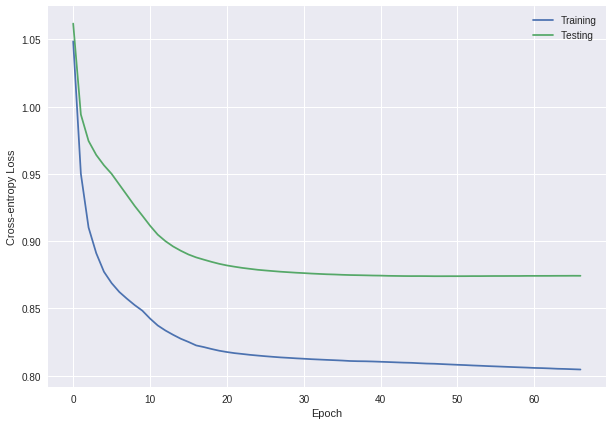

In [32]:
plt.style.use("seaborn")
plt.figure(figsize=(10, 7))
plt.plot(training_loss[::ceil(len(training) / batch_size)])
plt.plot(testing_loss[::ceil(len(training) / batch_size)])
plt.legend(["Training", "Testing"])
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
pass

In [33]:
model = get_model(state_dict=optimal_model_state_dict)
model.eval()

Model(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Softmax()
  )
  (cross_entropy): CrossEntropyLoss()
)

In [35]:
_, predictions, _ = model(*testing_inputs)

In [37]:
print(classification_report(testing.stances, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58       230
           1       0.75      0.45      0.56       304
           2       0.72      0.78      0.75       715

    accuracy                           0.68      1249
   macro avg       0.66      0.63      0.63      1249
weighted avg       0.69      0.68      0.67      1249



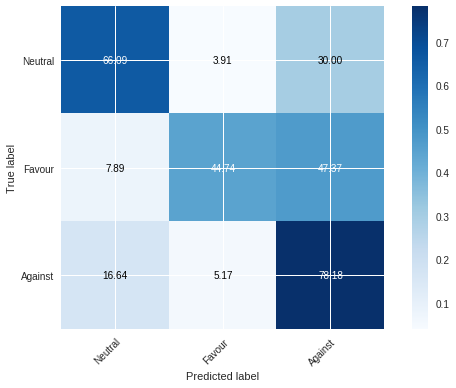

In [42]:
plot_confusion_matrix(testing.stances, predictions.cpu())